In [4]:
import numpy as np
import pandas as pd
import string
import spacy
import math
import re
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional
from keras.models import Model
import tensorflow as tf
from  matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Google Colab - ALab/Data/ML_NOAC_NOVA_Extraction_Cleaned_DF3_Full.csv")
data.head()

In [7]:
emails_train, emails_test, target_train, target_test = train_test_split(data["LastEmailContent"],data["Type"],test_size = 0.2) 

In [8]:
def to_lower(word):
    result = word.lower()
    return result

In [9]:
def remove_punctuation(word):
    result= word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

In [10]:
def remove_stop_words(words):
    result = [i for i in words if i not in ENGLISH_STOP_WORDS]
    return result

In [11]:
def remove_hyperlink(word):
    return re.sub(r"http\S+", "", word)

In [12]:
def replace_newline(word):
    return word.replace('\n','')

In [13]:
def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

In [14]:
def remove_whitespace(word):
    result = word.strip()
    return result

In [15]:
def introduce_empty(word):
    if not word or not isinstance(word, str) or len(word) == 0:
        return "[EMPTY]"
    return word

In [16]:
def make_str(word):
    if not isinstance(word, str):
        return ""
    return str(word)

In [17]:
def clean_up_pipeline(sentence):
    cleaning_utils = [make_str,
                      #remove_hyperlink,
                      #replace_newline,
                      #to_lower,
                      #remove_number,
                      #remove_punctuation,
                      #remove_whitespace,
                      introduce_empty]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

In [ ]:
x_train = [clean_up_pipeline(o) for o in tqdm(emails_train)]

100%|██████████| 200987/200987 [00:00<00:00, 744577.81it/s]


In [ ]:
x_test = [clean_up_pipeline(o) for o in tqdm(emails_test)]

100%|██████████| 50247/50247 [00:00<00:00, 818063.65it/s]


In [ ]:
le = LabelEncoder()
train_y = le.fit_transform(target_train.values)
test_y = le.transform(target_test.values)

In [ ]:
## some config values 
embed_size = 512 # how big is each word vector
max_feature = 50000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 2048 # max number of words in a question to use

In [ ]:
tokenizer = Tokenizer(num_words=max_feature)
tokenizer.fit_on_texts(x_train)
x_train_features = np.array(tokenizer.texts_to_sequences(x_train))
x_test_features = np.array(tokenizer.texts_to_sequences(x_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [ ]:
x_train_features = pad_sequences(x_train_features,maxlen=max_len)
x_test_features = pad_sequences(x_test_features,maxlen=max_len)

In [ ]:
#size of the output vector from each layer
embedding_vector_length = 32
#Creating a sequential model
model = tf.keras.Sequential()
#Creating an embedding layer to vectorize
model.add(Embedding(max_feature, embedding_vector_length, input_length=max_len))
#Addding Bi-directional LSTM
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
#Relu allows converging quickly and allows backpropagation
model.add(Dense(16, activation='relu'))
#Deep Learninng models can be overfit easily, to avoid this, we add randomization using drop out
model.add(Dropout(0.1))
#Adding sigmoid activation function to normalize the output
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Precision()])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2048, 32)          1600000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49664     
 l)                                                              
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,651,745
Trainable params: 1,651,745
Non-trainable params: 0
______________________________________________

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU'))) #print no of GPU device

Num GPUs Available:  1


In [ ]:
history = model.fit(x_train_features, train_y, batch_size=512, epochs=20, validation_data=(x_test_features, test_y))

Epoch 1/20
393/393 [==============================] - 138s 333ms/step - loss: 0.5031 - precision: 0.6199 - val_loss: 0.4651 - val_precision: 0.6347
Epoch 2/20
393/393 [==============================] - 124s 315ms/step - loss: 0.4342 - precision: 0.6735 - val_loss: 0.4400 - val_precision: 0.6719
Epoch 3/20
393/393 [==============================] - 123s 314ms/step - loss: 0.4063 - precision: 0.6982 - val_loss: 0.4433 - val_precision: 0.6791
Epoch 4/20
393/393 [==============================] - 122s 310ms/step - loss: 0.3864 - precision: 0.7173 - val_loss: 0.4406 - val_precision: 0.6425
Epoch 5/20
393/393 [==============================] - 122s 309ms/step - loss: 0.3689 - precision: 0.7304 - val_loss: 0.4494 - val_precision: 0.6759
Epoch 6/20
393/393 [==============================] - 122s 310ms/step - loss: 0.3544 - precision: 0.7455 - val_loss: 0.4617 - val_precision: 0.6583
Epoch 7/20
393/393 [==============================] - 121s 309ms/step - loss: 0.3441 - precision: 0.7536 - val_l

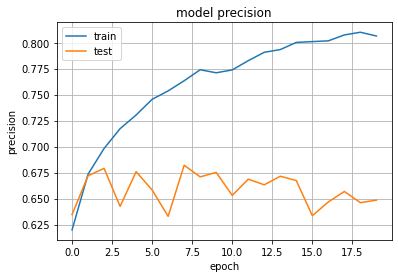

In [ ]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]

1571/1571 [==============================] - 72s 45ms/step


In [ ]:
cf_matrix =confusion_matrix(test_y,y_predict)

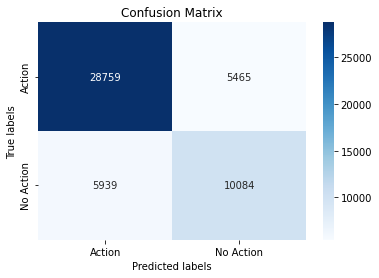

In [ ]:
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt=''); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Action', 'No Action']); ax.yaxis.set_ticklabels(['Action', 'No Action']);

In [ ]:
print("Precision: {:.2f}%".format(100 * precision_score(test_y, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(test_y, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_y,y_predict)))

Precision: 64.85%
Recall: 62.93%
F1 Score: 63.88%


In [ ]:
model.save('model')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


--------------------------------------------

In [1]:
from transformers import pipeline
model = pipeline("sentiment-analysis", model="distilbert-base-uncased", tokenizer="distilbert-base-uncased")

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

In [18]:
def clean_up_pipeline(sentence):
    cleaning_utils = [make_str,
                      #remove_hyperlink,
                      #replace_newline,
                      #to_lower,
                      #remove_number,
                      #remove_punctuation,
                      #remove_whitespace,
                      introduce_empty]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

In [19]:
# apply the preprocessing function to emails_train
x_train = [clean_up_pipeline(o) for o in tqdm(emails_train)]
x_test = [clean_up_pipeline(o) for o in tqdm(emails_test)]

100%|██████████| 50247/50247 [00:00<00:00, 840704.60it/s]


In [ ]:
x_train_tokenized = model.tokenizer(x_train, return_tensors="np", padding="max_length", truncation=True)
x_test_tokenized = model.tokenizer(x_test, return_tensors="np", padding="max_length", truncation=True)